In [1]:
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from os.path import join, dirname, abspath
import shap
import tqdm

/opt/homebrew/Caskroom/miniconda/base/envs/SaaLab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Only Peptides

In [ ]:
metadata = pd.read_csv(join('..', 'Data', 'metadata.csv')).dropna()
metadata['sample_id'] = metadata['sample_id'].apply(lambda x: str(x).replace('.', '-'))
metadata
metadata.set_index('sample_id', inplace = True)
exist_data = pd.read_csv(join('..', 'Data', 'exist.csv'))
exist_data = exist_data.T 
exist_data.columns = exist_data.iloc[0]
exist_data = exist_data[1:]

X = exist_data.copy().astype('category')

y = metadata['type_person']
y = y.apply(lambda x: 0 if x == 'Control' else 1).astype('category')

In [31]:
X.columns

Index(['agilent_10', 'agilent_100076', 'agilent_100147', 'agilent_100176',
       'agilent_100204', 'agilent_100206', 'agilent_100215', 'agilent_100240',
       'agilent_100245', 'agilent_100253',
       ...
       'twist_99737', 'twist_9974', 'twist_9975', 'twist_9977', 'twist_99804',
       'twist_99816', 'twist_99830', 'twist_99880', 'twist_99911',
       'twist_99954'],
      dtype='object', name='peptide_name', length=13106)

In [60]:
# feature selection
from sklearn.model_selection import LeaveOneOut
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'seed': 100,
    'alpha': 0.2
}

# Jackknife unbiased 
loo = LeaveOneOut()

importance = []
for x in tqdm.tqdm(loo.split(X), total=X.shape[0], desc='Leave-One-Out Cross-Validation'):
    train_index, test_index = x
    bst = XGBClassifier(**params, n_estimators=100, enable_categorical=True)
    bst.fit(X.iloc[train_index], y.iloc[train_index]) 
    shap_exp = shap.TreeExplainer(bst)
    shap_values = shap_exp.shap_values(X.iloc[test_index])
    importance.append(np.abs(shap_values).mean(axis=0))





Leave-One-Out Cross-Validation: 100%|██████████| 80/80 [09:15<00:00,  6.94s/it]


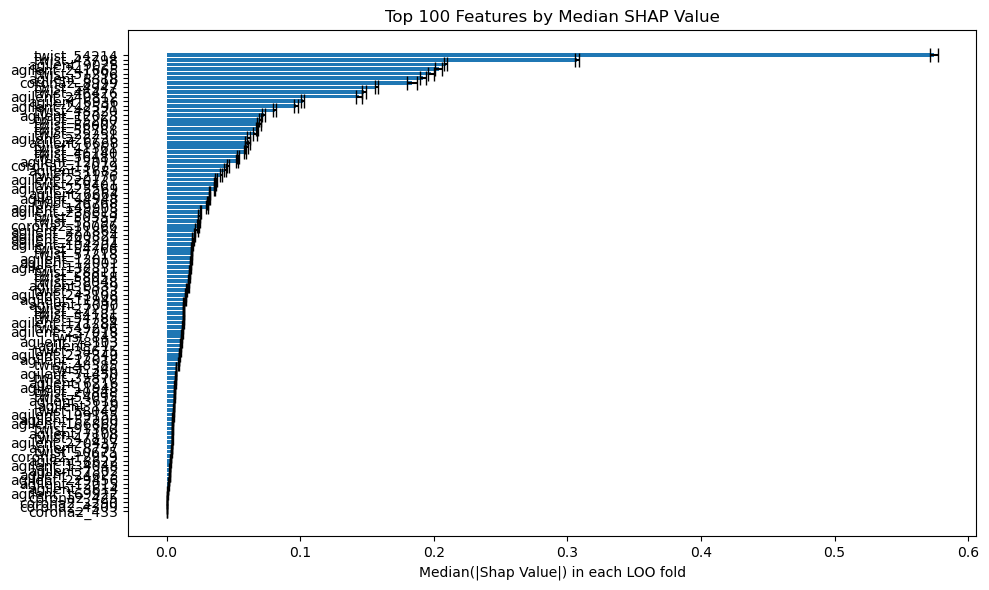

In [66]:
# convert to pandas
importance_df = pd.DataFrame(importance, columns=X.columns)

median_importance = importance_df.median(axis = 0).sort_values(ascending=False)
std_importance = importance_df.std(axis = 0).sort_values(ascending=False)   
im_100_best = median_importance[:100]
im_100_best_std = std_importance[im_100_best.index]/80 # std error

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(im_100_best.index, im_100_best.values, xerr=im_100_best_std.values, capsize=5)
plt.xlabel('Median(|Shap Value|) in each LOO fold')
plt.title('Top 100 Features by Median SHAP Value')
plt.gca().invert_yaxis()  
plt.tight_layout()

In [68]:
im_100_best.to_csv(join('..', 'Results', 'Top100_SHAP_peptides_only.csv'))

# Peptides plus Clinical Data

In [72]:
metadata = pd.read_csv(join('..', 'Data', 'metadata.csv')).dropna()
metadata['sample_id'] = metadata['sample_id'].apply(lambda x: str(x).replace('.', '-'))
metadata
metadata.set_index('sample_id', inplace = True)
exist_data = pd.read_csv(join('..', 'Data', 'exist.csv'))
exist_data = exist_data.T 
exist_data.columns = exist_data.iloc[0]
exist_data = exist_data[1:]
### Combine metadata and PCA results
metadata_things = metadata[['sex', 'age', 'type_person', 'diagnosis', 'appendectomy', 'smoking']]

concat_pep_meta = pd.concat([metadata_things, exist_data], axis = 1)


In [73]:
def smoking(x):
    if x == 'Never':
        return 0
    elif x == 'Ex_smoker':
        return 1
    elif x == 'Current_smoker':
        return 2
    else:
        return np.nan
    
    
X = concat_pep_meta.copy()
X.drop(columns = ['type_person', 'diagnosis'], inplace = True)
# encoding
X['sex'] = X['sex'].apply(lambda x: 0 if x == 'Male' else 1)

X['appendectomy'] = X['appendectomy'].apply(lambda x: 0 if x == 'No' else 1)
X['smoking'] = X['smoking'].apply(lambda x: smoking(x))
X = X.astype('category')
y = concat_pep_meta['type_person']
y = y.apply(lambda x: 0 if x == 'Control' else 1)

In [74]:
# feature selection
from sklearn.model_selection import LeaveOneOut
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'seed': 100,
    'alpha': 0.2
}
loo = LeaveOneOut()

importance = []
for x in tqdm.tqdm(loo.split(X), total=X.shape[0], desc='Leave-One-Out Cross-Validation'):
    train_index, test_index = x
    bst = XGBClassifier(**params, n_estimators=100, enable_categorical=True)
    bst.fit(X.iloc[train_index], y.iloc[train_index]) 
    shap_exp = shap.TreeExplainer(bst)
    shap_values = shap_exp.shap_values(X.iloc[test_index])
    importance.append(np.abs(shap_values).mean(axis=0))



Leave-One-Out Cross-Validation: 100%|██████████| 80/80 [09:04<00:00,  6.81s/it]


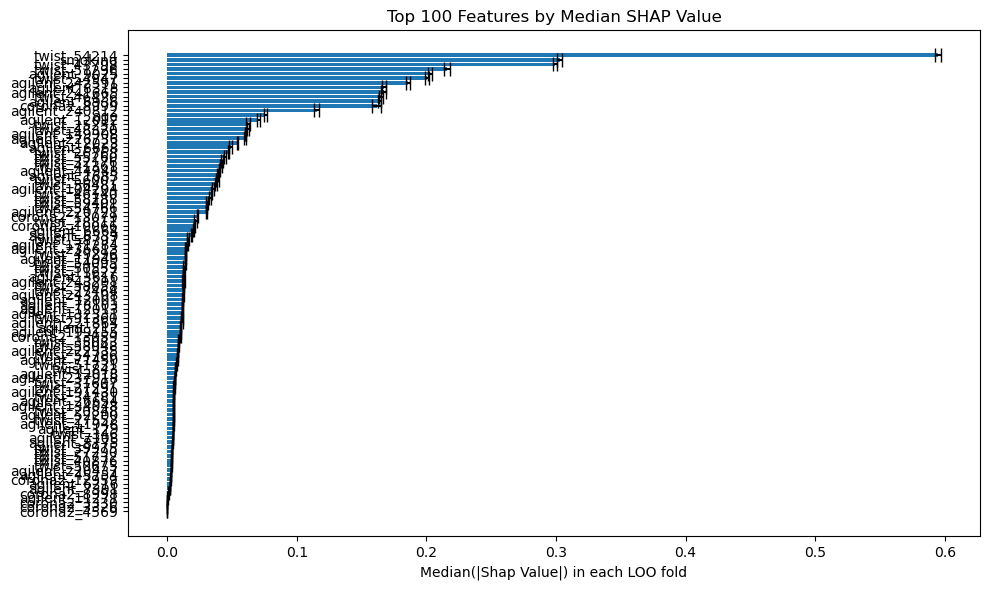

In [75]:
# convert to pandas
importance_df = pd.DataFrame(importance, columns=X.columns)

median_importance = importance_df.median(axis = 0).sort_values(ascending=False)
std_importance = importance_df.std(axis = 0).sort_values(ascending=False)   
im_100_best = median_importance[:100]
im_100_best_std = std_importance[im_100_best.index]/80 # std error

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(im_100_best.index, im_100_best.values, xerr=im_100_best_std.values, capsize=5)
plt.xlabel('Median(|Shap Value|) in each LOO fold')
plt.title('Top 100 Features by Median SHAP Value')
plt.gca().invert_yaxis()  
plt.tight_layout()

In [76]:
pep_best_shap = pd.concat([im_100_best, im_100_best_std], axis = 1)
pep_best_shap.columns = ['median_shap', 'std_error']
pep_best_shap.to_csv(join('..', 'Results', 'Top100_SHAP_peptides_and_clinical.csv'))